# Audio Feature Extraction using Librosa

### Import libraries

In [1]:
%matplotlib inline  
import librosa
import librosa.display
import IPython
import numpy as np
import pandas as pd
import scipy
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [132]:
audio = librosa.util.example_audio_file() 
# audio = 'test_audio/3.mp3'
y,sr=librosa.load(audio)

### Audio Overview

In [133]:
print('Audio Sampling Rate: '+str(sr)+' samples/sec')
print('Total Samples: '+str(np.size(y)))
secs=np.size(y)/sr
print('Audio Length: '+str(secs)+' s')
IPython.display.Audio(audio)

Audio Sampling Rate: 22050 samples/sec
Total Samples: 1355168
Audio Length: 61 s


## Feature Extraction

To determine the music genre of a music piece, a
number of content-based features are first extracted. In
general, the features employed for music classification can
be roughly categorized into three classes: timbral texture,
rhythmic features, and pitch content features. 

Timbral features are generally characterized by the properties
related to instrumentations or sound sources such as music,
speech, or environment signals. The features used to
represent the timbral texture of a music track include zero
crossing, spectral centroid, spectral flux, spectral rolloff,
Mel-frequency cepstral coefficients (MFCC),
Daubechies wavelet coefficients histograms (DWCH),
and octave-based spectral contrast (OSC), etc. 

Rhythmic features provide the main beat and its strength of
a music track. Several beat-tracking algorithms have been
proposed to estimate the main beat and the corresponding
strength. Pitch features, mainly derived from the
pitch histogram, describe the melody of the music. 
### Seperation of Harmonic and Percussive Signals

Text(0.5,1,u'Harmonic + Percussive')

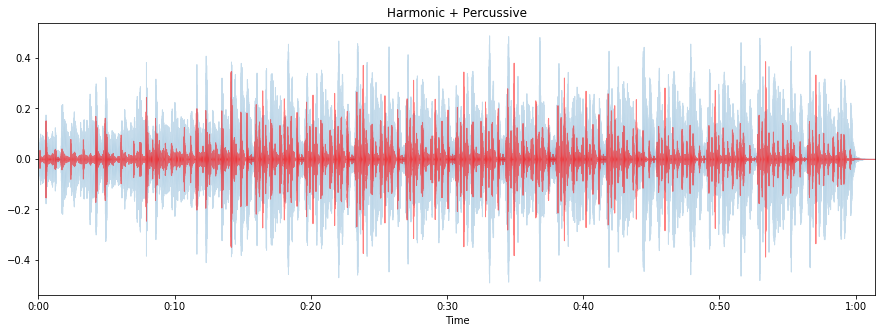

In [4]:
y_harmonic, y_percussive = librosa.effects.hpss(y)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(y_harmonic, sr=sr, alpha=0.25)
librosa.display.waveplot(y_percussive, sr=sr, color='r', alpha=0.5)
plt.title('Harmonic + Percussive')

### 1. Beat Extraction
The output of the beat tracker is an estimate of the tempo (in beats per minute), and an array of frame numbers corresponding to detected beat events.

Frames here correspond to short windows of the signal (y), each separated by hop_length = 512 samples. Since v0.3, librosa uses centered frames, so that the kth frame is centered around sample k 

We will use the average tempo of the song as a feature.

Detected Tempo: 129.19921875 beats/min


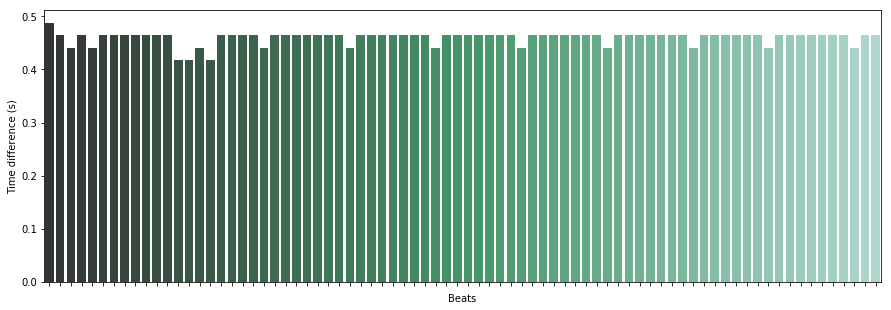

In [5]:
tempo, beat_frames = librosa.beat.beat_track(y=y_harmonic, sr=sr)
print('Detected Tempo: '+str(tempo)+ ' beats/min')
beat_times = librosa.frames_to_time(beat_frames, sr=sr)
beat_time_diff=np.ediff1d(beat_times)
beat_nums = np.arange(1, np.size(beat_times))

fig, ax = plt.subplots()
fig.set_size_inches(15, 5)
ax.set_ylabel("Time difference (s)")
ax.set_xlabel("Beats")
g=sns.barplot(beat_nums, beat_time_diff, palette="BuGn_d",ax=ax)
g=g.set(xticklabels=[])


### 2. Chroma Energy Normalized (CENS)

Calculate the Chroma Energy Normalized (CENS) for the audio file. A 12-element representation of the spectral energy where the bins represent the 12 equal-tempered pitch classes of western-type music (semitone spacing).


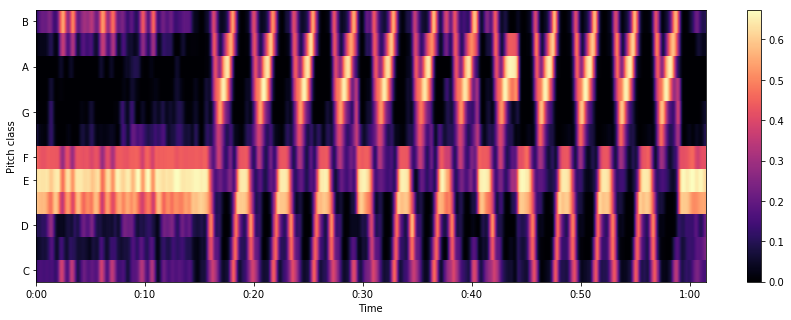

In [6]:
chroma=librosa.feature.chroma_cens(y=y_harmonic, sr=sr)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chroma,y_axis='chroma', x_axis='time')
plt.colorbar()

### 3. Calculate MFCCs

Mel-frequency cepstral coefficients (MFCCs) are coefficients that collectively make up an MFC. They are derived from a type of cepstral representation of the audio clip (a nonlinear "spectrum-of-a-spectrum"). The difference between the cepstrum and the mel-frequency cepstrum is that in the MFC, the frequency bands are equally spaced on the mel scale, which approximates the human auditory system's response more closely than the linearly-spaced frequency bands used in the normal cepstrum. This frequency warping can allow for better representation of sound, for example, in audio compression.

Text(0.5,1,u'MFCC')

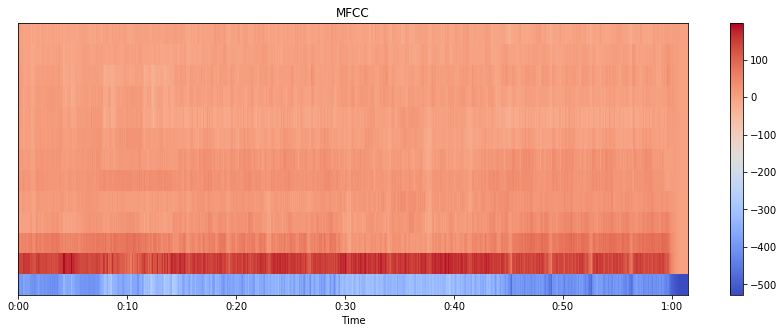

In [7]:
mfccs = librosa.feature.mfcc(y=y_harmonic, sr=sr, n_mfcc=13)
plt.figure(figsize=(15, 5))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')


### 4. Spectral Centroid

The spectral centroid is a measure used in digital signal processing to characterise a spectrum. It indicates where the "center of mass" of the spectrum is. Perceptually, it has a robust connection with the impression of "brightness" of a sound.

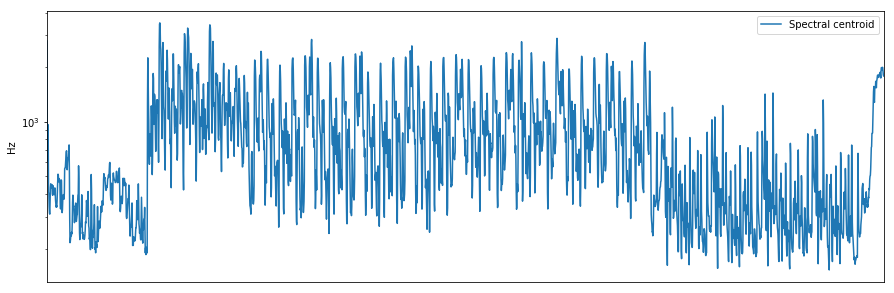

In [8]:
cent = librosa.feature.spectral_centroid(y=y, sr=sr)
plt.figure(figsize=(15,5))
plt.subplot(1, 1, 1)
plt.semilogy(cent.T, label='Spectral centroid')
plt.ylabel('Hz')
plt.xticks([])
plt.xlim([0, cent.shape[-1]])
plt.legend()

### 5. Spectral Contrast

OSC was developed to represent the spectral characteristics
of a music piece. It considers the spectral peak and valley in
each sub-band separately. In general, spectral peaks
correspond to harmonic components and spectral valleys
correspond to non-harmonic components or noise in a
music piece. Therefore, the difference between spectral
peaks and spectral valleys will reflect the spectral contrast
distribution. 

Text(0.5,1,u'Spectral contrast')

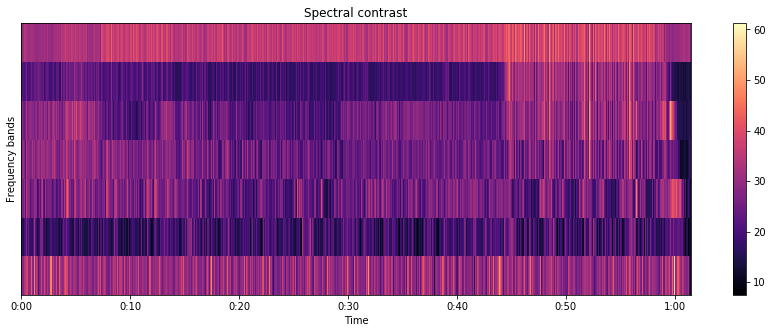

In [9]:
contrast=librosa.feature.spectral_contrast(y=y_harmonic,sr=sr)
plt.figure(figsize=(15,5))
librosa.display.specshow(contrast, x_axis='time')
plt.colorbar()
plt.ylabel('Frequency bands')
plt.title('Spectral contrast')

### 6. Spectral Rolloff

Spectral rolloff point is defined as the Nth percentile of the power spectral distribution, where N is usually 85% or 95%. The rolloff point is the frequency below which the N% of the magnitude distribution is concentrated.

This measure is useful in distinguishing voiced speech from unvoiced: unvoiced speech has a high proportion of energy contained in the high-frequency range of the spectrum, where most of the energy for voiced speech and music is contained in lower bands.


In [10]:
rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
plt.figure(figsize=(15,5))
plt.semilogy(rolloff.T, label='Roll-off frequency')
plt.ylabel('Hz')
plt.xticks([])
plt.xlim([0, rolloff.shape[-1]])
plt.legend()

### 7. Zero Crossing Rate

A zero crossing point, is a point in a digital audio file where the sample is at zero amplitude. At any other point, the amplitude of the wave is rising towards its peak or sinking towards its trough.

The zero-crossing rate is the rate of sign-changes along a signal, i.e., the rate at which the signal changes from positive to negative or back. This feature has been used heavily in both speech recognition and music information retrieval, being a key feature to classify percussive sounds.

In [11]:
zrate=librosa.feature.zero_crossing_rate(y_harmonic)
plt.figure(figsize=(15,5))
plt.semilogy(zrate.T, label='Fraction')
plt.ylabel('Fraction per Frame')
plt.xticks([])
plt.xlim([0, rolloff.shape[-1]])
plt.legend()

## Feature Generation

This section will use the features extracted in the previous section and generate summary features for the entire song.

### 1. Chroma Energy Normalized

The output of CENS contains the 12 element representation of the chroma energy thoroughout the song. The 12 element each will be summarized using mean and standard deviation accross the entire song.


chroma_mean_0  chroma_mean_1  chroma_mean_2  chroma_mean_3  chroma_mean_4  \
0       0.192055       0.149163       0.155541       0.340208       0.402254   

   chroma_mean_5  chroma_mean_6  chroma_mean_7  chroma_mean_8  chroma_mean_9  \
0       0.301493       0.125393       0.132842       0.193738       0.185472   

       ...        chroma_std_2  chroma_std_3  chroma_std_4  chroma_std_5  \
0      ...             0.13782      0.226182      0.227696      0.128671   

   chroma_std_6  chroma_std_7  chroma_std_8  chroma_std_9  chroma_std_10  \
0      0.113077      0.164462      0.229809      0.220716       0.173809   

   chroma_std_11  
0       0.154616  

[1 rows x 24 columns]

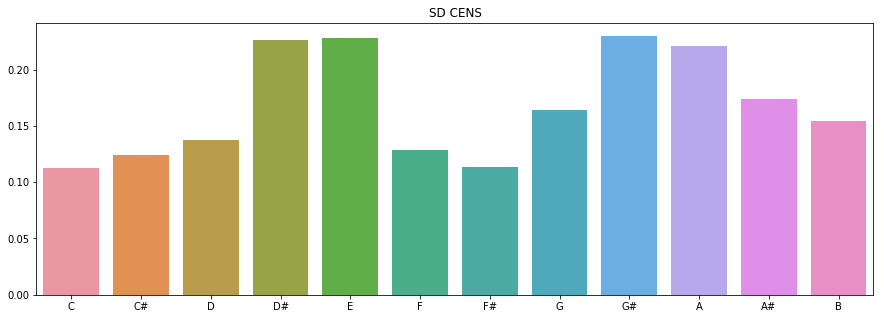

In [12]:
chroma_mean=np.mean(chroma,axis=1)
chroma_std=np.std(chroma,axis=1)
#plot the summary
octave=['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']
plt.figure(figsize=(15,5))
plt.title('Mean CENS')
sns.barplot(x=octave,y=chroma_mean)

plt.figure(figsize=(15,5))
plt.title('SD CENS')
sns.barplot(x=octave,y=chroma_std)
#Generate the chroma Dataframe
chroma_df=pd.DataFrame()
for i in range(0,12):
    chroma_df['chroma_mean_'+str(i)]=chroma_mean[i]
for i in range(0,12):
    chroma_df['chroma_std_'+str(i)]=chroma_mean[i]
chroma_df.loc[0]=np.concatenate((chroma_mean,chroma_std),axis=0)

chroma_df

### 2. MFCCs

To characterize the whole music
piece, the mean and standard deviation of MFCC of all
frames in a music piece are used as features. 

In [13]:
mfccs_mean=np.mean(mfccs,axis=1)
mfccs_std=np.std(mfccs,axis=1)

coeffs=np.arange(0,13)
plt.figure(figsize=(15,5))
plt.title('Mean MFCCs')
sns.barplot(x=coeffs,y=mfccs_mean)

plt.figure(figsize=(15,5))
plt.title('SD MFCCs')
sns.barplot(x=coeffs,y=mfccs_std)
#Generate the chroma Dataframe
mfccs_df=pd.DataFrame()
for i in range(0,13):
    mfccs_df['mfccs_mean_'+str(i)]=mfccs_mean[i]
for i in range(0,13):
    mfccs_df['mfccs_std_'+str(i)]=mfccs_mean[i]
mfccs_df.loc[0]=np.concatenate((mfccs_mean,mfccs_std),axis=0)
mfccs_df

mfccs_mean_0  mfccs_mean_1  mfccs_mean_2  mfccs_mean_3  mfccs_mean_4  \
0   -366.980437      141.9711     53.233424     23.804767     18.531365   

   mfccs_mean_5  mfccs_mean_6  mfccs_mean_7  mfccs_mean_8  mfccs_mean_9  \
0     26.322677       18.8613      7.818049      1.041555      6.360767   

       ...       mfccs_std_3  mfccs_std_4  mfccs_std_5  mfccs_std_6  \
0      ...         14.405838     9.510955     9.159723    10.697894   

   mfccs_std_7  mfccs_std_8  mfccs_std_9  mfccs_std_10  mfccs_std_11  \
0     8.911054    10.036312     7.902091      9.111539      6.170943   

   mfccs_std_12  
0      6.218396  

[1 rows x 26 columns]

### 3. Spectral Features

#### Spectral Centroid

In [14]:
cent_mean=np.mean(cent)
cent_std=np.std(cent)
cent_skew=scipy.stats.skew(cent,axis=1)[0]
print('Mean: '+str(cent_mean))
print('SD: '+str(cent_std))
print('Skewness: '+str(cent_skew))

Mean: 809.3506932341368
SD: 595.2926743795158
Skewness: 1.341753043380963


#### Spectral Contrast

In [15]:
contrast_mean=np.mean(contrast,axis=1)
contrast_std=np.std(contrast,axis=1)

conts=np.arange(0,7)
plt.figure(figsize=(15,5))
plt.title('Mean Spectral Contrast')
sns.barplot(x=conts,y=contrast_mean)

plt.figure(figsize=(15,5))
plt.title('SD Spectral Contrast')
sns.barplot(x=conts,y=contrast_std)
#Generate the chroma Dataframe
contrast_df=pd.DataFrame()

#### Spectral Rolloff

In [16]:
rolloff_mean=np.mean(rolloff)
rolloff_std=np.std(rolloff)
rolloff_skew=scipy.stats.skew(rolloff,axis=1)[0]
print('Mean: '+str(rolloff_mean))
print('SD: '+str(rolloff_std))
print('Skewness: '+str(rolloff_skew))

Mean: 1621.1077140689931
SD: 1649.3321925637604
Skewness: 1.6359262029371993


In [17]:
spectral_df=pd.DataFrame()
collist=['cent_mean','cent_std','cent_skew']
for i in range(0,7):
    collist.append('contrast_mean_'+str(i))
for i in range(0,7):
    collist.append('contrast_std_'+str(i))
collist=collist+['rolloff_mean','rolloff_std','rolloff_skew']
for c in collist:
    spectral_df[c]=0
data=np.concatenate(([cent_mean,cent_std,cent_skew],contrast_mean,contrast_std,[rolloff_mean,rolloff_std,rolloff_std]),axis=0)
spectral_df.loc[0]=data
spectral_df

cent_mean    cent_std  cent_skew  contrast_mean_0  contrast_mean_1  \
0  809.350693  595.292674   1.341753        30.332658        18.987942   

   contrast_mean_2  contrast_mean_3  contrast_mean_4  contrast_mean_5  \
0        25.229415         26.03485        26.084748        22.446577   

   contrast_mean_6  contrast_std_0  contrast_std_1  contrast_std_2  \
0        35.893514        5.069161        4.824427        5.690817   

   contrast_std_3  contrast_std_4  contrast_std_5  contrast_std_6  \
0        5.043755        5.811027        6.160046        3.478273   

   rolloff_mean  rolloff_std  rolloff_skew  
0   1621.107714  1649.332193   1649.332193

### 4. Zero Crossing Rate

In [18]:
zrate_mean=np.mean(zrate)
zrate_std=np.std(zrate)
zrate_skew=scipy.stats.skew(zrate,axis=1)[0]
print('Mean: '+str(zrate_mean))
print('SD: '+str(zrate_std))
print('Skewness: '+str(zrate_skew))

Mean: 0.01712304761286362
SD: 0.011693080201145784
Skewness: 1.9743027222936487


In [19]:
zrate_df=pd.DataFrame()
zrate_df['zrate_mean']=0
zrate_df['zrate_std']=0
zrate_df['zrate_skew']=0
zrate_df.loc[0]=[zrate_mean,zrate_std,zrate_skew]
zrate_df

zrate_mean  zrate_std  zrate_skew
0    0.017123   0.011693    1.974303

###  5. Beat and Tempo

In [20]:
beat_df=pd.DataFrame()
beat_df['tempo']=tempo
beat_df.loc[0]=tempo
beat_df

tempo
0  129.199219

## Generate the Final DataFrame

In [21]:
final_df=pd.concat((chroma_df,mfccs_df,spectral_df,zrate_df,beat_df),axis=1)
final_df.head()

chroma_mean_0  chroma_mean_1  chroma_mean_2  chroma_mean_3  chroma_mean_4  \
0       0.192055       0.149163       0.155541       0.340208       0.402254   

   chroma_mean_5  chroma_mean_6  chroma_mean_7  chroma_mean_8  chroma_mean_9  \
0       0.301493       0.125393       0.132842       0.193738       0.185472   

      ...      contrast_std_4  contrast_std_5  contrast_std_6  rolloff_mean  \
0     ...            5.811027        6.160046        3.478273   1621.107714   

   rolloff_std  rolloff_skew  zrate_mean  zrate_std  zrate_skew       tempo  
0  1649.332193   1649.332193    0.017123   0.011693    1.974303  129.199219  

[1 rows x 74 columns]

In [2]:
def create_chroma_df(chroma):
    chroma_mean=np.mean(chroma,axis=1)
    chroma_std=np.std(chroma,axis=1)
    #Generate the chroma Dataframe
    chroma_df=pd.DataFrame()
    for i in range(0,12):
        chroma_df['chroma_mean_'+str(i)]=chroma_mean[i]
    for i in range(0,12):
        chroma_df['chroma_std_'+str(i)]=chroma_mean[i]
    chroma_df.loc[0]=np.concatenate((chroma_mean,chroma_std),axis=0)

    return chroma_df

In [3]:
def create_mfccs_df(mfccs):
    mfccs_mean=np.mean(mfccs,axis=1)
    mfccs_std=np.std(mfccs,axis=1)
    #Generate the chroma Dataframe
    mfccs_df=pd.DataFrame()
    for i in range(0,13):
        mfccs_df['mfccs_mean_'+str(i)]=mfccs_mean[i]
    for i in range(0,13):
        mfccs_df['mfccs_std_'+str(i)]=mfccs_mean[i]
    mfccs_df.loc[0]=np.concatenate((mfccs_mean,mfccs_std),axis=0)
    return mfccs_df

In [4]:
def create_spectral_df(cent, contrast, rolloff):
    cent_mean=np.mean(cent)
    cent_std=np.std(cent)
    cent_skew=scipy.stats.skew(cent,axis=1)[0]

    contrast_mean=np.mean(contrast,axis=1)
    contrast_std=np.std(contrast,axis=1)
    
    rolloff_mean=np.mean(rolloff)
    rolloff_std=np.std(rolloff)
    rolloff_skew=scipy.stats.skew(rolloff,axis=1)[0]

    spectral_df=pd.DataFrame()
    collist=['cent_mean','cent_std','cent_skew']
    for i in range(0,7):
        collist.append('contrast_mean_'+str(i))
    for i in range(0,7):
        collist.append('contrast_std_'+str(i))
    collist=collist+['rolloff_mean','rolloff_std','rolloff_skew']
    for c in collist:
        spectral_df[c]=0
    data=np.concatenate(([cent_mean,cent_std,cent_skew],contrast_mean,contrast_std,[rolloff_mean,rolloff_std,rolloff_std]),axis=0)
    spectral_df.loc[0]=data
    return spectral_df


In [5]:
def create_zrate_df(zrate):
    zrate_mean=np.mean(zrate)
    zrate_std=np.std(zrate)
    zrate_skew=scipy.stats.skew(zrate,axis=1)[0]

    zrate_df=pd.DataFrame()
    zrate_df['zrate_mean']=0
    zrate_df['zrate_std']=0
    zrate_df['zrate_skew']=0
    zrate_df.loc[0]=[zrate_mean,zrate_std,zrate_skew]
    return zrate_df


In [6]:
def create_beat_df(tempo):
    beat_df=pd.DataFrame()
    beat_df['tempo']=tempo
    beat_df.loc[0]=tempo
    return beat_df

In [19]:
def extract_features(audio):
    y,sr=librosa.load(audio)
    y_harmonic, y_percussive = librosa.effects.hpss(y)
    
    tempo, beat_frames = librosa.beat.beat_track(y=y_harmonic, sr=sr)
    beat_times = librosa.frames_to_time(beat_frames, sr=sr)
    beat_time_diff=np.ediff1d(beat_times)
    beat_nums = np.arange(1, np.size(beat_times))
    
    chroma=librosa.feature.chroma_cens(y=y_harmonic, sr=sr)
    
    mfccs = librosa.feature.mfcc(y=y_harmonic, sr=sr, n_mfcc=13)
    
    cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    
    contrast=librosa.feature.spectral_contrast(y=y_harmonic,sr=sr)
    
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    
    zrate=librosa.feature.zero_crossing_rate(y_harmonic)
    
    chroma_df = create_chroma_df(chroma)
    
    mfccs_df = create_mfccs_df(mfccs)
    
    spectral_df = create_spectral_df(cent, contrast, rolloff)
    
    zrate_df = create_zrate_df(zrate)
    
    beat_df = create_beat_df(tempo)
    
    id_df = pd.DataFrame({'id' : [audio.split('/')[1].split('.')[0]]})
    final_df = pd.concat((id_df, chroma_df,mfccs_df,spectral_df,zrate_df,beat_df),axis=1)
    
    return final_df
 

In [22]:
all_songs = []
count = 1
for filename in os.listdir('MEMD_audio'):
    song = extract_features('MEMD_audio/' + filename)
    all_songs.append(song)
    print str(count) + ' ',
    count += 1
        
features = pd.concat(all_songs)
features.set_index(features['id'],inplace = True)
features.to_csv('librosa_features.csv', index=False)

1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99  100  101  102  103  104  105  106  107  108  109  110  111  112  113  114  115  116  117  118  119  120  121  122  123  124  125  126  127  128  129  130  131  132  133  134  135  136  137  138  139  140  141  142  143  144  145  146  147  148  149  150  151  152  153  154  155  156  157  158  159  160  161  162  163  164  165  166  167  168  169  170  171  172  173  174  175  176  177  178  179  180  181  182  183  184  185  186  187  188  189  190  191  192  193  194  195  196  197  198  199  200  201  202  203  204  205  206  207  208  209  210  211  212  213  214  215  216  217  218  219  220  221  222